# Model testing 

## Import libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate

import cv2

#%%
# Data Loader
import sys
# path = os.getcwd()
#sys.path.insert(0, '/Users/pauli/Documents/Studium/Master/3. Semester Auslandssemester DTU/Deep Learning/Final Project/Otovo/')
#from autotetris.dataloader import RoofDataSet
from lib.dataloader import RoofDataSet, Transforms
from modeltraining import Resnet18, PadMSEloss, VarMSEloss, train_model, test_model

## Import path

In [2]:
path = 'C:/Users/guzma/OneDrive/Documents/TEC/DTU/02456/Project/Github_Project/Dataset/data_2022-11-01/meta_data.hdf'
input_path = path

## Data Loading

In [3]:
dataset = RoofDataSet(path, transform=Transforms(new_size=(256,256)), mode = "constant")
imp_path = dataset.image_paths +  "/"+dataset.id[0]+"-b15-otovowms.jpeg"
image = cv2.imread(imp_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#%%
# split the dataset into training, validation and test sets
# Create testset
len_test_set = int(0.1*len(dataset))
len_train_set = len(dataset) - len_test_set

-------------------- Initializing dataset --------------------
--> Metadata read
--> Num_panels computed
--> Samples with many panels dropped
--> Padding samples
--> Dataset ready


## Train test split

In [4]:
train_dataset , test_dataset  = torch.utils.data.random_split(dataset, [len_train_set, len_test_set])


len_valid_set = int(0.1*len(train_dataset))
len_train_set = len(train_dataset) - len_valid_set

train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [len_train_set, len_valid_set])

In [5]:
print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))
print("The length of Test set is {}".format(len_test_set))


# shuffle and batch the datasets
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(x_.to("cpu") for x_ in default_collate(x)))
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

The length of Train set is 30083
The length of Valid set is 3342
The length of Test set is 3713


## Model Training

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
#%%
image, centroid = next(iter(train_loader))
# print(image.shape, centroid.shape, centroid)
#%%
network = Resnet18()
network.to(device)
# print(network)

# Adjust network parameter
criterion = VarMSEloss()
optimizer = optim.Adam(network.parameters(), lr=0.01)

loss_min = 0.001
num_epochs = 10

# Train model
model = train_model(network, criterion, optimizer, num_epochs, train_loader, valid_loader, device)

torch.save(model, 'resnet18_constant_minus100_28_11_22_j.pt')

cuda
Valid Steps: 105/105  Loss: 39251.9047  
--------------------------------------------------
Epoch: 1  Train Loss: 57974.8996  Valid Loss: 39251.9047
--------------------------------------------------
Valid Steps: 105/105  Loss: 30307.3854 
--------------------------------------------------
Epoch: 2  Train Loss: 39408.7407  Valid Loss: 30307.3854
--------------------------------------------------
Valid Steps: 105/105  Loss: 32272.0290 
--------------------------------------------------
Epoch: 3  Train Loss: 34934.3205  Valid Loss: 32272.0290
--------------------------------------------------
Valid Steps: 105/105  Loss: 29536.1252 
--------------------------------------------------
Epoch: 4  Train Loss: 33042.6387  Valid Loss: 29536.1252
--------------------------------------------------
Valid Steps: 105/105  Loss: 23324.9246 
--------------------------------------------------
Epoch: 5  Train Loss: 30409.0778  Valid Loss: 23324.9246
--------------------------------------------------

## Model Testing

In [7]:
model = Resnet18()
# path = 'trained_models/resnet18_wrap_27_11_22.pt'
path = 'resnet18_constant_minus100_28_11_22_j.pt'
model = torch.load(path,map_location=torch.device('cpu'))
# model.load_state(torch.load('C:/Users/guzma/OneDrive/Documents/TEC/DTU/02456/Project/Github_Project/autotetris/resnet18_constant_minus100_28_11_22_j.pt'))
# model.eval()

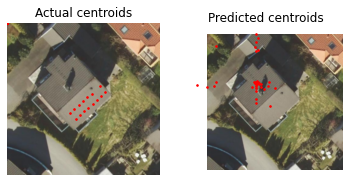

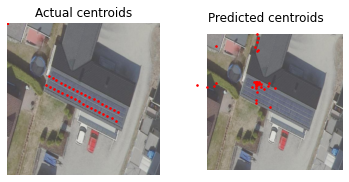

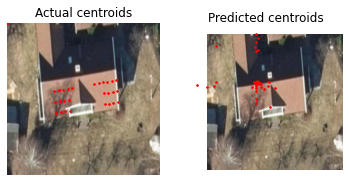

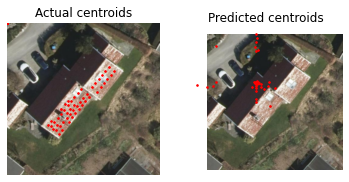

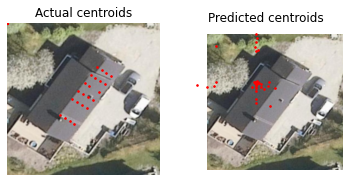

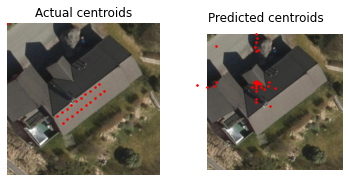

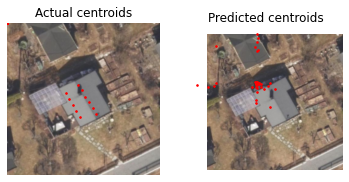

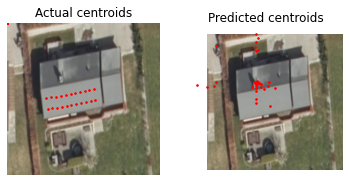

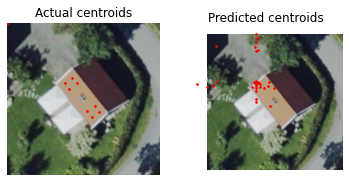

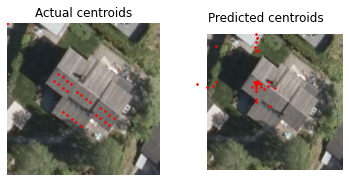

[tensor([[[ 88.0657,  93.7555],
          [101.4304, 127.8642],
          [ 97.3212, 115.4146],
          [101.8570, 107.4875],
          [ 98.6037, 101.4922],
          [100.8220,  93.2862],
          [ 91.4332,  92.5477],
          [ 91.0351,  95.8463],
          [ 90.9368,  92.7507],
          [ 91.0848,  98.6853],
          [107.2363,  93.4398],
          [ 93.9957,  93.6407],
          [ 30.6879,  93.3845],
          [ 91.4778,  94.9501],
          [ 13.8443,  93.3773],
          [ 94.1679, -19.1092],
          [ 97.5294,  92.9427],
          [ 92.2761,  92.7538],
          [122.2958,  92.7318],
          [128.3043,  92.6630],
          [ 92.9037,  92.9757],
          [ 91.2955,  93.4256],
          [135.6990, 119.0619],
          [ 92.0064,  93.1953],
          [ 93.3598, 101.3298],
          [ 90.8440,  92.3821],
          [ 90.0554,  93.2111],
          [ 99.2138,   0.5634],
          [ -0.7608,  93.3552],
          [ 89.5756,  94.5854],
          [ 90.1201, 117.7308],
        

In [8]:
test_model(model, test_loader, 10)

## Loss plot

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
val_los = pd.read_csv('val_loss_1.csv')
train_los = pd.read_csv('train_loss_1.csv')

<AxesSubplot:>

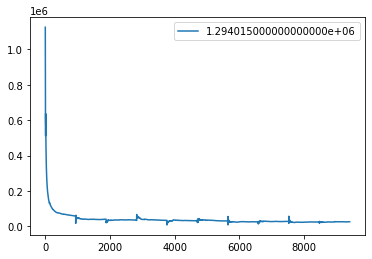

In [17]:
train_los.plot()
plt.title('Train Loss')

Text(0.5, 1.0, 'Validation Loss')

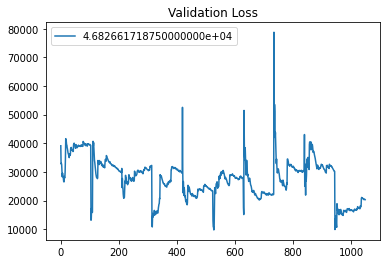

In [20]:
val_los.plot()
plt.title('Validation Loss')